In [14]:
import math
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import geojson
from mpas_tools.mesh.creation.signed_distance import mask_from_geojson

In [15]:
lev = xr.open_dataset('/pscratch/sd/a/abhi305/depth_files/hr_depth.nc').refBottomDepth
ds_v = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_velocityMeridional/mer_v_highres_111_120_re_time_av.nc')
ds_w = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_vertVelocityTop/vertVelocityTop_111_120_re_time_avg.nc')
ds_pd = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_potentialDensity/potentialDensity_111_120_re_time_av.nc')

In [16]:
v = ds_v.timeMonthly_avg_velocityMeridional[0,...].values
w = ds_w.timeMonthly_avg_vertVelocityTop[0,...].values
pd = ds_pd.timeMonthly_avg_potentialDensity[0,...].values
lat = ds_v.lat.values
lon = ds_v.lon.values

In [17]:
with open('/pscratch/sd/a/abhi305/mask_files/atlantic_mask.geojson') as f:
    fc = geojson.load(f) 
na_mask = mask_from_geojson(fc,lon,lat)   

Mask from geojson
-----------------


In [18]:
v[:,~na_mask] = np.nan
w[:,~na_mask] = np.nan
pd[:,~na_mask] = np.nan

In [19]:
dist_lon = 0.1*111*np.cos(np.deg2rad(lat))*1000 
dist_lat = 11076

In [20]:
v[v == 0] = np.nan
w[w == 0] = np.nan

# SOUTHERN TRANSECT

In [21]:
southern_boundary_lat_index = np.where(~np.isnan(v[0,:,1500]))[0].min()

In [22]:
#southern_boundary_lat_index = np.argmax(~np.isnan(v[0,:,800]))
v_south = v[:,southern_boundary_lat_index,:]

In [23]:
'''
fig,ax=plt.subplots(figsize=(8,6))
c = ax.pcolormesh(lon,lev,v_south,cmap='RdBu',vmin=-0.1,vmax=0.1)
ax.set_xlim(-60,20)
ax.set_ylim(4000,0)
cax = fig.add_axes([0.92,0.15,0.02,0.7])
fig.colorbar(c,cax=cax)
'''

"\nfig,ax=plt.subplots(figsize=(8,6))\nc = ax.pcolormesh(lon,lev,v_south,cmap='RdBu',vmin=-0.1,vmax=0.1)\nax.set_xlim(-60,20)\nax.set_ylim(4000,0)\ncax = fig.add_axes([0.92,0.15,0.02,0.7])\nfig.colorbar(c,cax=cax)\n"

In [24]:
layer_thickness = np.diff(lev, prepend=0)

In [25]:
v_south_dz = v_south * layer_thickness[:,None]

In [26]:
v_south_dz.shape

(80, 3600)

## Here goes isopycnal transformation

In [27]:
southern_transport_z = np.nansum(v_south_dz,axis=1)*9000

In [28]:
southern_psi = np.flip(np.nancumsum(np.flip(southern_transport_z)))

# INTERIOR

# W (zonal sum earlier)


In [29]:
w_zonalsum = np.nansum(w, axis=2)

In [30]:
w_zonalsum_da = w_zonalsum * dist_lon[None,:] * dist_lat 

In [31]:
w_zonalsum_da_diff = np.diff(w_zonalsum_da, axis=0)

In [32]:
w_zonalsum_da_diff_zcum = np.flip(np.nancumsum(np.flip(w_zonalsum_da_diff, axis=0), axis=0), axis=0)

In [33]:
w_zonalsum_da_diff_zcum_latcum = np.nancumsum(w_zonalsum_da_diff_zcum, axis=1)

# W (zonal sum later)

In [36]:
w_da = w * dist_lon[None,:,None] * dist_lat

In [37]:
w_da_diff = np.diff(w_da, axis=0)

## here goes isopycnal codes

### Zonal sum --> cumsum in depth --> cumsum in lat

In [38]:
w_da_diff.shape

(80, 1800, 3600)

In [39]:
w_da_diff_zonalsum = np.nansum(w_da_diff, axis=2)

In [40]:
w_da_diff_zonalsum.shape

(80, 1800)

In [41]:
w_da_diff_zonalsum_zcum = np.flip(np.nancumsum(np.flip(w_da_diff_zonalsum, axis=0), axis=0), axis=0)

In [42]:
w_da_diff_zonalsum_zcum.shape

(80, 1800)

In [43]:
w_da_diff_zonalsum_zcum_latcum = np.nancumsum(w_da_diff_zonalsum_zcum, axis=1)

In [44]:
w_da_diff_zonalsum_zcum_latcum.shape

(80, 1800)

### Cumsum in depth --> cumsum in lat --> Zonal sum 

In [19]:
w_da_diff_zcum = np.flip(np.nancumsum(np.flip(w_da_diff, axis=0), axis=0), axis=0)

In [21]:
w_da_diff_zcum_latcum = np.nancumsum(w_da_diff_zcum, axis=1)

In [22]:
w_da_diff_zcum_latcum.shape

(80, 1800, 3600)

In [ ]:
w_da_diff_zcum_latcum_zonalsum = np.nansum(w_da_diff_zcum_latcum, axis=2)

# Total psi (taking zonal mean first for Interior)

In [34]:
final_psi = -0.000001* (southern_psi[:,None] + w_zonalsum_da_diff_zcum_latcum)

/tmp/ipykernel_395457/1383818467.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


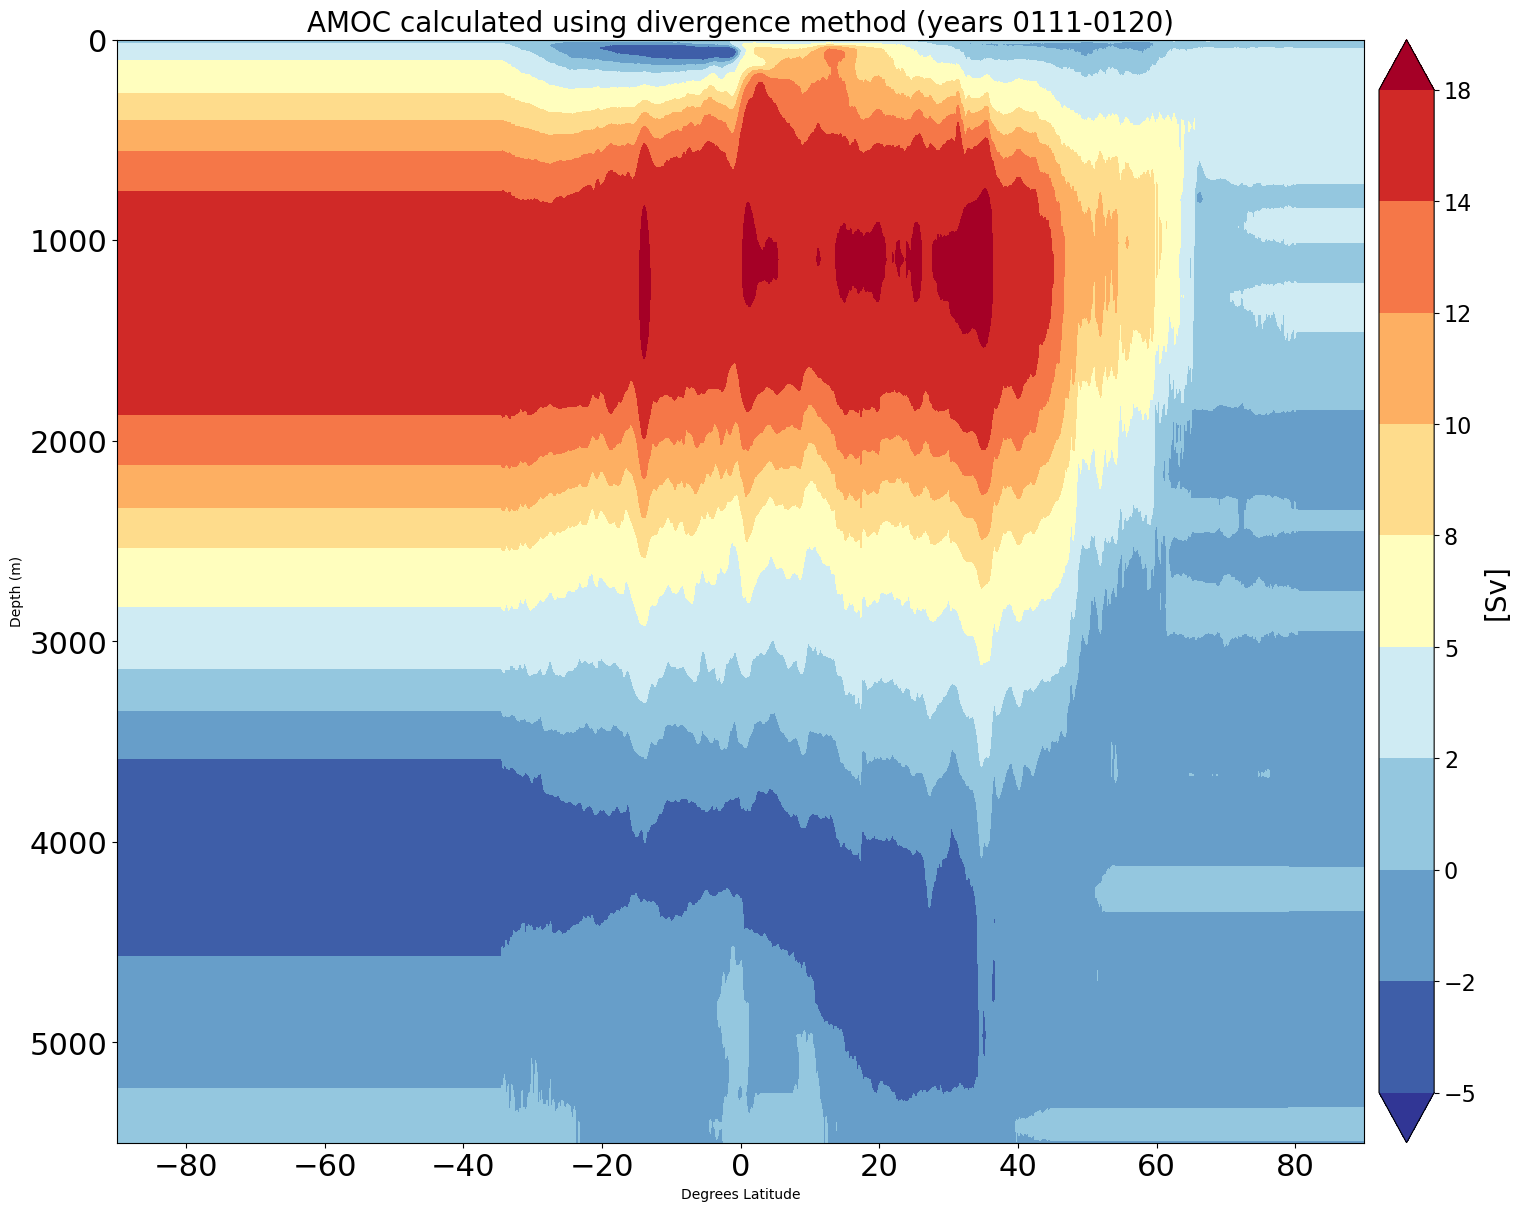

In [35]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat, lev, final_psi,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated using divergence method (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
#plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_div_years_0111_0120', dpi=300)

# Total psi (taking zonal mean later for Interior)

In [45]:
final_psi = -0.000001* (southern_psi[:,None] + w_da_diff_zonalsum_zcum_latcum)

/tmp/ipykernel_395457/1383818467.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


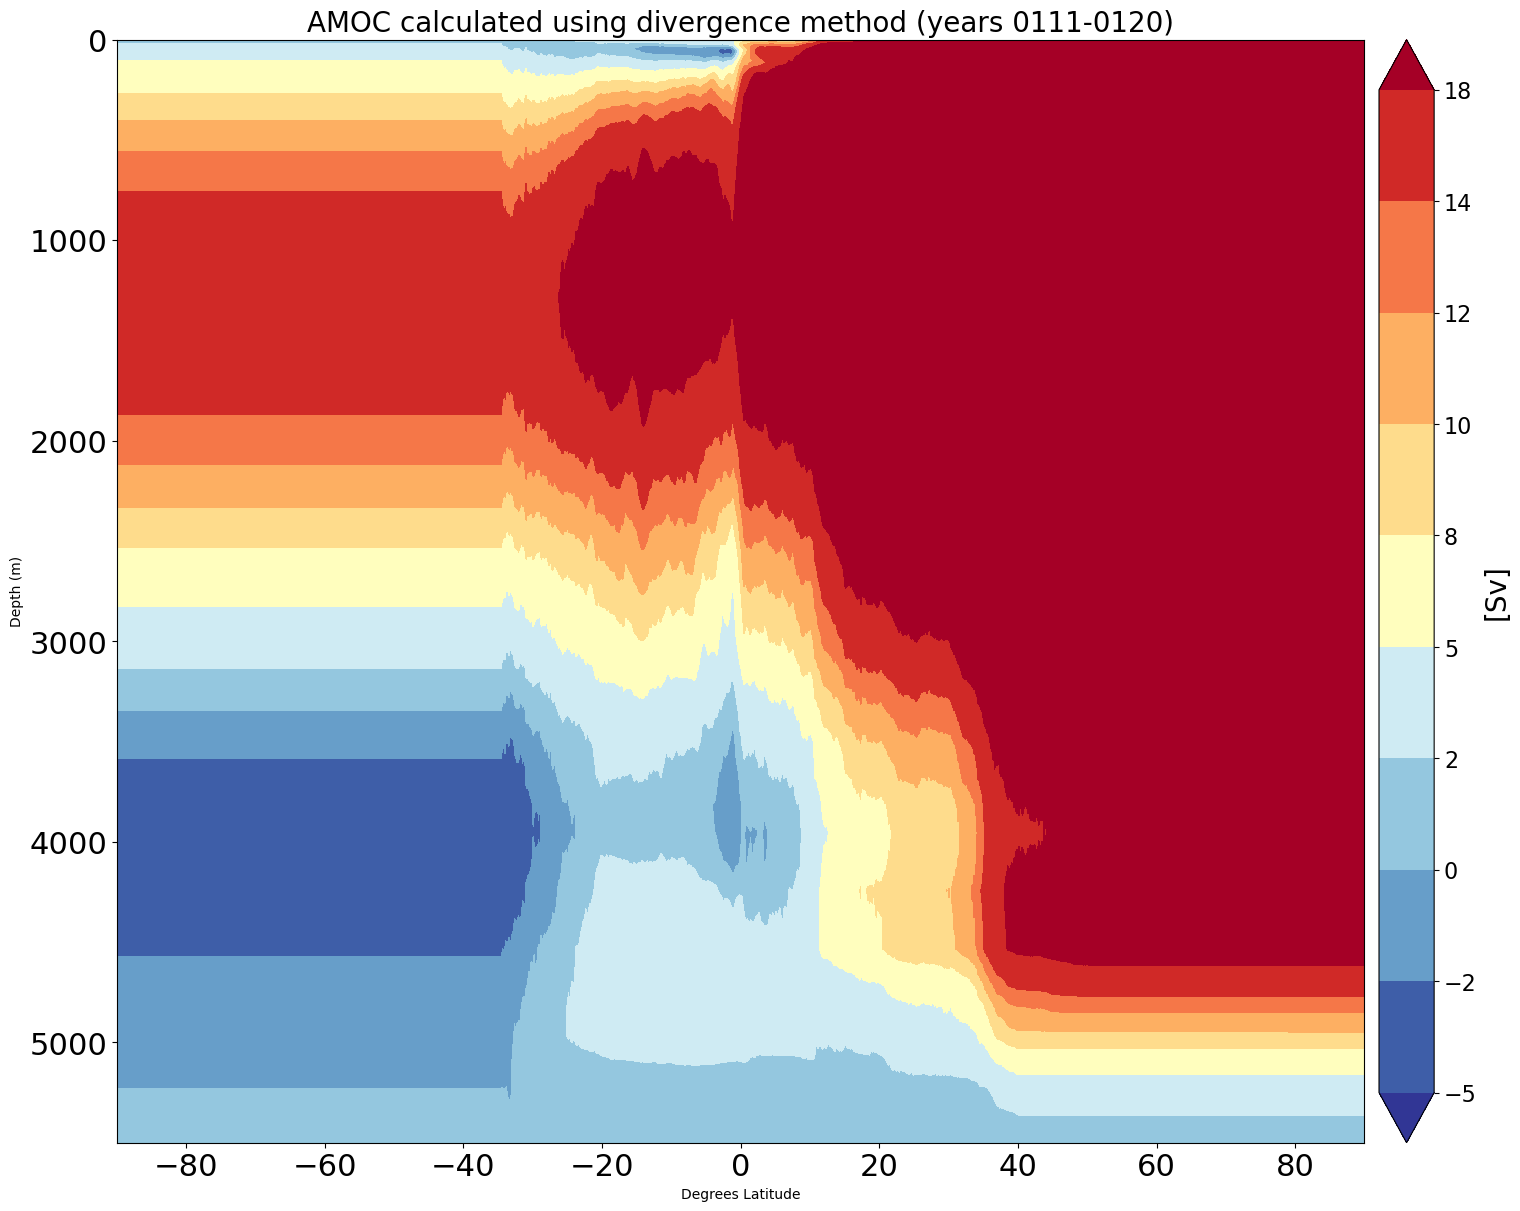

In [46]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat, lev, final_psi,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated using divergence method (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
#plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_div_years_0111_0120', dpi=300)